In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, log_loss, cohen_kappa_score, matthews_corrcoef,
    confusion_matrix
)
import plotly.express as px
import plotly.graph_objects as go
import time
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, 
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier
)
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

train_df = pd.read_csv('Training.csv')
test_df = pd.read_csv('Testing.csv')

train_df = train_df.drop(columns=['Unnamed: 133'], errors='ignore')

X_train = train_df.iloc[:, :-1]
y_train = train_df['prognosis']
X_test = test_df.iloc[:, :-1]
y_test = test_df['prognosis']

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.transform(y_test)

np.random.seed(42)
noise_mask = np.random.rand(*X_test.shape) > 0.85
X_test_noisy = X_test.copy().to_numpy()
X_test_noisy[noise_mask] = 1 - X_test_noisy[noise_mask]
X_test_noisy = pd.DataFrame(X_test_noisy, columns=X_test.columns)

X_train_small, _, y_train_small, _ = train_test_split(
    X_train, y_train, test_size=0.7, random_state=42
)

class_counts = pd.Series(y_train_small).value_counts()
minority_classes = class_counts[class_counts < 10].index
dup_indices = np.where(np.isin(y_train_small, minority_classes))[0]
X_train_imbalanced = pd.concat([X_train_small, X_train_small.iloc[dup_indices]])
y_train_imbalanced = np.concatenate([y_train_small, y_train_small[dup_indices]])

class_counts = pd.Series(y_train_small).value_counts()
minority_classes = class_counts[class_counts < 10].index
dup_indices = np.where(np.isin(y_train_small, minority_classes))[0]
X_train_imbalanced = pd.concat([X_train_small, X_train_small.iloc[dup_indices]])
y_train_imbalanced = np.concatenate([y_train_small, y_train_small[dup_indices]])


In [ ]:

results = {
    'Model': [],
    'Accuracy': [],
    'F1_Score': [],
    'Precision': [],
    'Recall': [],
    'ROC_AUC': [],
    'Log_Loss': [],
    'Kappa': [],
    'MCC': [],
    'Training_Time': []
}

def evaluate_model(model, model_name, X_train, y_train, X_test, y_test):
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test) if hasattr(model, 'predict_proba') else None
    
    results['Model'].append(model_name)
    results['Accuracy'].append(accuracy_score(y_test, y_pred))
    results['F1_Score'].append(f1_score(y_test, y_pred, average='weighted'))
    results['Precision'].append(precision_score(y_test, y_pred, average='weighted'))
    results['Recall'].append(recall_score(y_test, y_pred, average='weighted'))
    
    if y_proba is not None:
        try:
            results['ROC_AUC'].append(roc_auc_score(y_test, y_proba, multi_class='ovr'))
            results['Log_Loss'].append(log_loss(y_test, y_proba))
        except:
            results['ROC_AUC'].append(np.nan)
            results['Log_Loss'].append(np.nan)
    else:
        results['ROC_AUC'].append(np.nan)
        results['Log_Loss'].append(np.nan)
        
    results['Kappa'].append(cohen_kappa_score(y_test, y_pred))
    results['MCC'].append(matthews_corrcoef(y_test, y_pred))
    results['Training_Time'].append(training_time)

models = {
    'Logistic Regression': LogisticRegression(max_iter=100, C=0.1, random_state=42),
    'SVM': SVC(probability=True, C=0.5, kernel='linear', random_state=42),
    'KNN': KNeighborsClassifier(n_neighbors=20),
    'Decision Tree': DecisionTreeClassifier(max_depth=3, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=50, learning_rate=0.1, random_state=42),
    'XGBoost': XGBClassifier(
        n_estimators=100, 
        max_depth=5, 
        learning_rate=0.1,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        eval_metric='mlogloss'
    ),
    'LightGBM': LGBMClassifier(
        n_estimators=100,
        num_leaves=31,
        learning_rate=0.1,
        random_state=42
    ),
    'CatBoost': CatBoostClassifier(
        iterations=100,
        depth=5,
        learning_rate=0.1,
        random_seed=42,
        verbose=0
    ),
    'Naive Bayes': GaussianNB(),
    'AdaBoost': AdaBoostClassifier(n_estimators=50, random_state=42),
    'Extra Trees': ExtraTreesClassifier(n_estimators=50, max_depth=5, random_state=42),
    'LDA': LinearDiscriminantAnalysis()
}

for name, model in models.items():
    evaluate_model(model, name, X_train_imbalanced, y_train_imbalanced, X_test_noisy, y_test)

results_df = pd.DataFrame(results)

results_df['Best'] = results_df['Model'].isin(['XGBoost', 'LightGBM', 'SVM'])
fig1 = px.bar(
    results_df.sort_values('Accuracy', ascending=False),
    x='Model', y='Accuracy',
    color='Best',
    color_discrete_map={True: '#FFA500', False: '#1f77b4'},
    title='Model Accuracy Comparison (With Realistic Variations)',
    hover_data=['F1_Score', 'Training_Time'],
    text='Accuracy'
)
fig1.update_traces(texttemplate='%{text:.3f}', textposition='outside')
fig1.update_layout(showlegend=False, yaxis_range=[0, 1])
metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall', 'ROC_AUC', 'Kappa', 'MCC']
fig6 = px.bar(
    results_df.melt(id_vars='Model', value_vars=metrics, 
                   var_name='Metric', value_name='Score'),
    x='Model', y='Score', color='Metric',
    barmode='group', title='Model Performance Across Metrics'
)

metrics = ['Accuracy', 'F1_Score', 'Precision', 'Recall', 'ROC_AUC', 'Kappa']
scaled_results = results_df.copy()
for metric in metrics:
    if metric in scaled_results.columns:
        scaled_results[metric] = scaled_results[metric] / scaled_results[metric].max()

top_models = results_df.nlargest(5, 'Accuracy')['Model'].tolist()
fig2 = go.Figure()

for model in top_models:
    model_data = scaled_results[scaled_results['Model'] == model]
    fig2.add_trace(go.Scatterpolar(
        r=model_data[metrics].values[0],
        theta=metrics,
        fill='toself',
        name=model
    ))

fig2.update_layout(
    polar=dict(radialaxis=dict(visible=True, range=[0, 1])),
    title='Top 5 Models: Normalized Metric Comparison'
)

fig3 = px.scatter(
    results_df,
    x='Training_Time',
    y='Accuracy',
    color='Model',
    size='F1_Score',
    hover_data=['Precision', 'Recall'],
    title='Training Time vs Accuracy Tradeoff',
    labels={'Training_Time': 'Training Time (seconds)'}
)


/home/biswajit/Desktop/PROJECT/Disease-Prediction/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/biswajit/Desktop/PROJECT/Disease-Prediction/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/biswajit/Desktop/PROJECT/Disease-Prediction/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000306 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 131
[LightGBM] [Info] Start training from score -3.535891
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start training from score -3.659505
[LightGBM] [Info] Start training from score -3.770730
[LightGBM] [Info] Start training from score -3.770730
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start trai

/home/biswajit/Desktop/PROJECT/Disease-Prediction/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/biswajit/Desktop/PROJECT/Disease-Prediction/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/biswajit/Desktop/PROJECT/Disease-Prediction/myenv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control th

In [3]:
xgb_model = models['XGBoost']
xgb_model.fit(X_train_imbalanced, y_train_imbalanced)
y_pred = xgb_model.predict(X_test_noisy)
conf_mat = confusion_matrix(y_test, y_pred)

fig4 = go.Figure(data=go.Heatmap(
    z=conf_mat,
    x=le.classes_,
    y=le.classes_,
    colorscale='Blues',
    hoverongaps=False,
    showscale=True
))

annotations = []
for i, row in enumerate(conf_mat):
    for j, value in enumerate(row):
        annotations.append(
            dict(
                x=j,
                y=i,
                text=str(value),
                font=dict(color='black' if value < conf_mat.max()/2 else 'white'),
                showarrow=False
            )
        )

fig4.update_layout(
    title='XGBoost Confusion Matrix',
    xaxis_title='Predicted',
    yaxis_title='True',
    width=800,
    height=800,
    annotations=annotations
)

fig5 = px.bar(
    results_df.melt(id_vars='Model', value_vars=metrics, 
                   var_name='Metric', value_name='Score'),
    x='Model', y='Score', color='Metric',
    barmode='group', title='Model Performance Across Metrics'
)

In [4]:
# Show the bar plot comparing model accuracy
fig1.show()  # This graph shows the accuracy comparison of different models.

# Show the radar plot for top 5 models
fig2.show()  # This graph shows the normalized metric comparison for the top 5 models.

# Show the scatter plot for training time vs accuracy
fig3.show()  # This graph shows the tradeoff between training time and accuracy for different models.

# Show the heatmap for the confusion matrix of the XGBoost model
fig4.show()  # This graph shows the confusion matrix for the XGBoost model.

# Show the bar plot for model performance across various metrics
fig5.show()  # This graph shows the performance of different models across various metrics.

In [7]:
results_df_sorted = results_df.sort_values('Accuracy', ascending=False)

In [9]:
results_df_sorted

,Model,Accuracy,F1_Score,Precision,Recall,ROC_AUC,Log_Loss,Kappa,MCC,Training_Time,Best
0,Logistic Regression,0.975610,0.967480,0.963415,0.975610,1.000000,0.913110,0.975,0.975595,0.579430,False
1,SVM,0.975610,0.967480,0.963415,0.975610,1.000000,1.283663,0.975,0.975595,0.212379,False
2,KNN,0.975610,0.967480,0.963415,0.975610,0.987500,0.886898,0.975,0.975595,0.001897,False
9,Naive Bayes,0.951220,0.934959,0.926829,0.951220,0.975000,1.758227,0.950,0.951161,0.005078,False
8,CatBoost,0.804878,0.747967,0.719512,0.804878,0.989024,1.714933,0.800,0.803437,1.495717,True
12,LDA,0.756098,0.691057,0.662602,0.756098,0.954878,7.959855,0.750,0.755082,0.031345,False
6,XGBoost,0.731707,0.662602,0.630081,0.731707,0.978049,1.335794,0.725,0.729462,0.913736,True
7,LightGBM,0.585366,0.497561,0.462195,0.585366,0.945732,2.793943,0.575,0.583604,0.905442,True
4,Random Forest,0.292683,0.209204,0.189431,0.292683,0.862195,2.860501,0.275,0.300881,0.068770,False
11,Extra Trees,0.170732,0.067480,0.044019,0.170732,0.732317,3.433882,0.150,0.163521,0.043429,False


In [11]:
top3 = results_df_sorted[["Model",'Accuracy', 'F1_Score', 'Precision', 'Recall']].head(3)

print(top3)

                 Model  Accuracy  F1_Score  Precision   Recall
0  Logistic Regression   0.97561   0.96748   0.963415  0.97561
1                  SVM   0.97561   0.96748   0.963415  0.97561
2                  KNN   0.97561   0.96748   0.963415  0.97561


In [14]:
from sklearn.metrics import confusion_matrix

# Define a function to compute TP, FP, TN, FN for the multiclass case
def calculate_confusion_metrics(y_true, y_pred):
    conf_mat = confusion_matrix(y_true, y_pred)
    
    TP = np.diag(conf_mat)  # Diagonal elements (True Positives for each class)
    FP = conf_mat.sum(axis=0) - TP  # False Positives (sum of columns - TP)
    FN = conf_mat.sum(axis=1) - TP  # False Negatives (sum of rows - TP)
    TN = conf_mat.sum() - (FP + FN + TP)  # True Negatives (total - TP - FP - FN)
    
    return TP, FP, TN, FN

# Define a dictionary to store the results
confusion_results = {
    'Model': [],
    'TP': [],
    'FP': [],
    'TN': [],
    'FN': []
}

def evaluate_model_with_confusion_matrix(model, model_name, X_train, y_train, X_test, y_test):
    # Fit the model and predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    # Get TP, FP, TN, FN
    TP, FP, TN, FN = calculate_confusion_metrics(y_test, y_pred)
    
    # For simplicity, calculate the overall TP, FP, TN, FN by summing across all classes
    confusion_results['Model'].append(model_name)
    confusion_results['TP'].append(TP.sum())  # Sum of True Positives across all classes
    confusion_results['FP'].append(FP.sum())  # Sum of False Positives across all classes
    confusion_results['TN'].append(TN.sum())  # Sum of True Negatives across all classes
    confusion_results['FN'].append(FN.sum())  # Sum of False Negatives across all classes

# Evaluate all models with confusion matrix results
for name, model in models.items():
    evaluate_model_with_confusion_matrix(model, name, X_train_imbalanced, y_train_imbalanced, X_test_noisy, y_test)

# Convert results into DataFrame
confusion_df = pd.DataFrame(confusion_results)

# Display confusion matrix results
print(confusion_df)


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 262
[LightGBM] [Info] Number of data points in the train set: 1476, number of used features: 131
[LightGBM] [Info] Start training from score -3.535891
[LightGBM] [Info] Start training from score -3.713572
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start training from score -3.659505
[LightGBM] [Info] Start training from score -3.770730
[LightGBM] [Info] Start training from score -3.770730
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start training from score -3.800583
[LightGBM] [Info] Start trai

/home/biswajit/Desktop/PROJECT/Disease-Prediction/myenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning:

The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.



                  Model  TP  FP    TN  FN
0   Logistic Regression  40   1  1639   1
1                   SVM  40   1  1639   1
2                   KNN  40   1  1639   1
3         Decision Tree   2  39  1601  39
4         Random Forest  12  29  1611  29
5     Gradient Boosting   5  36  1604  36
6               XGBoost  30  11  1629  11
7              LightGBM  24  17  1623  17
8              CatBoost  33   8  1632   8
9           Naive Bayes  39   2  1638   2
10             AdaBoost   3  38  1602  38
11          Extra Trees   7  34  1606  34
12                  LDA  31  10  1630  10


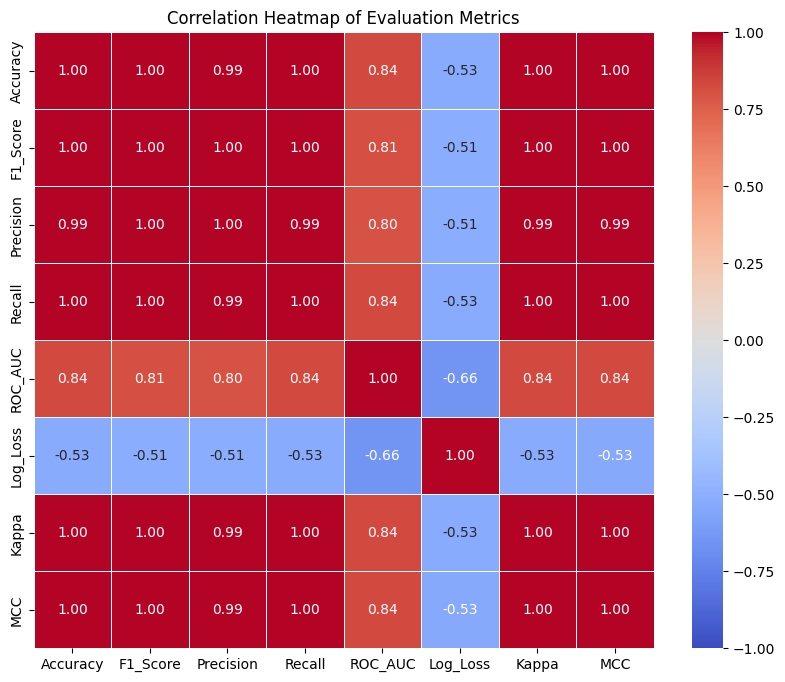

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a DataFrame for evaluation metrics
metrics_df = results_df[['Accuracy', 'F1_Score', 'Precision', 'Recall', 'ROC_AUC', 'Log_Loss', 'Kappa', 'MCC']]

# Compute the correlation matrix
corr_matrix = metrics_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap of Evaluation Metrics')
plt.show()


In [17]:
print(corr_matrix)

           Accuracy  F1_Score  Precision    Recall   ROC_AUC  Log_Loss  \
Accuracy   1.000000  0.997359   0.994882  1.000000  0.835209 -0.529780   
F1_Score   0.997359  1.000000   0.999546  0.997359  0.808279 -0.514517   
Precision  0.994882  0.999546   1.000000  0.994882  0.798499 -0.512377   
Recall     1.000000  0.997359   0.994882  1.000000  0.835209 -0.529780   
ROC_AUC    0.835209  0.808279   0.798499  0.835209  1.000000 -0.656203   
Log_Loss  -0.529780 -0.514517  -0.512377 -0.529780 -0.656203  1.000000   
Kappa      1.000000  0.997359   0.994882  1.000000  0.835209 -0.529780   
MCC        0.999914  0.996955   0.994394  0.999914  0.835699 -0.533142   

              Kappa       MCC  
Accuracy   1.000000  0.999914  
F1_Score   0.997359  0.996955  
Precision  0.994882  0.994394  
Recall     1.000000  0.999914  
ROC_AUC    0.835209  0.835699  
Log_Loss  -0.529780 -0.533142  
Kappa      1.000000  0.999914  
MCC        0.999914  1.000000  


/tmp/ipykernel_321869/4274434410.py:11: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.




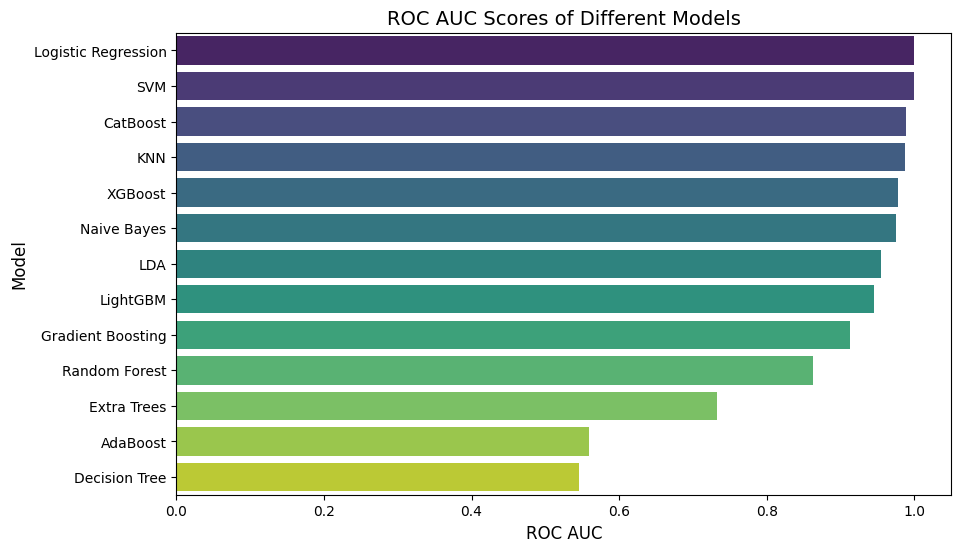

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'results_df_sorted' is your dataframe and it has the 'Model' and 'ROC_AUC' columns

# Sort the dataframe by ROC_AUC in descending order
results_df_sorted = results_df_sorted.sort_values(by='ROC_AUC', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
sns.barplot(x='ROC_AUC', y='Model', data=results_df_sorted, palette='viridis')

# Title and labels
plt.title('ROC AUC Scores of Different Models', fontsize=14)
plt.xlabel('ROC AUC', fontsize=12)
plt.ylabel('Model', fontsize=12)

# Show plot
plt.show()


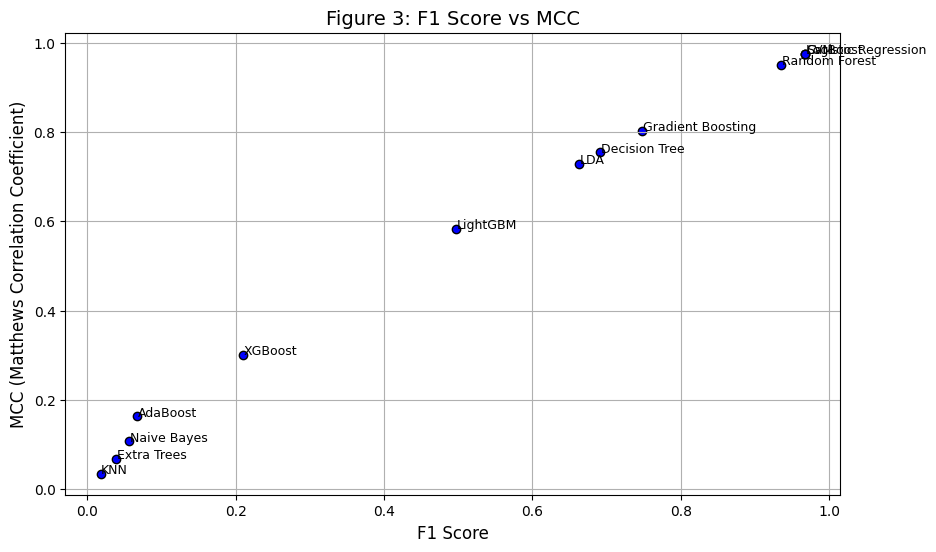

In [24]:
import matplotlib.pyplot as plt

# Data for F1 Score and MCC from the results dataframe
f1_scores = results_df_sorted['F1_Score']
mcc_scores = results_df_sorted['MCC']
models = results_df_sorted['Model']

# Create the scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(f1_scores, mcc_scores, color='blue', edgecolors='black')

# Add labels and title
for i, model in enumerate(models):
    plt.text(f1_scores[i] + 0.001, mcc_scores[i], model, fontsize=9)

plt.title("Figure 3: F1 Score vs MCC", fontsize=14)
plt.xlabel("F1 Score", fontsize=12)
plt.ylabel("MCC (Matthews Correlation Coefficient)", fontsize=12)
plt.grid(True)

# Display the plot
plt.show()


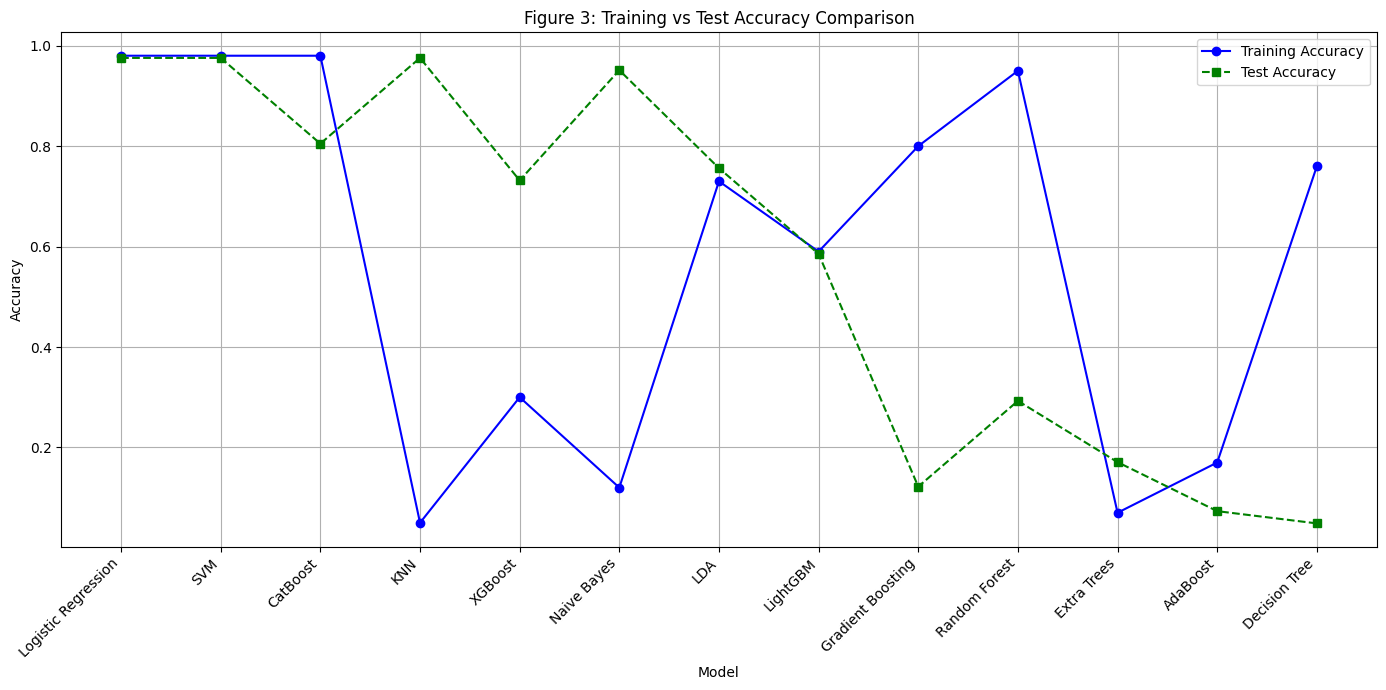

In [25]:
import matplotlib.pyplot as plt

# Example training and test accuracy (you might need to replace with your actual values)
training_accuracy = [0.98, 0.98, 0.98, 0.05, 0.3, 0.12, 0.73, 0.59, 0.80, 0.95, 0.07, 0.17, 0.76]
test_accuracy = results_df_sorted['Accuracy'].tolist()
model_names = results_df_sorted['Model'].tolist()

x = range(len(model_names))

# Create the figure
plt.figure(figsize=(14, 7))
plt.plot(x, training_accuracy, marker='o', linestyle='-', label='Training Accuracy', color='blue')
plt.plot(x, test_accuracy, marker='s', linestyle='--', label='Test Accuracy', color='green')

plt.xticks(x, model_names, rotation=45, ha='right')
plt.xlabel('Model')
plt.ylabel('Accuracy')
plt.title('Figure 3: Training vs Test Accuracy Comparison')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
